# Writing a training loop from scratch
https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

## Import libraries

In [1]:
# Python libraries
import os
import pandas as pd # for data manipulation
import numpy as np # for data manipulation
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# To enable LaTeX and select a font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# Using ipynb import functions defined in other nb
from ipynb.fs.defs.myfun_load_dataset import *
from ipynb.fs.full.myfun_models import *
from ipynb.fs.full.myfun_nn import *
from ipynb.fs.defs.myfun_plot import *

2023-08-27 22:41:12.268752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow/Keras: 2.11.0
sklearn: 1.3.0


## Data Acquisition

In [2]:
# Load the dataset
par_dir = os.path.dirname(os.getcwd()) # parent dir
dir_name = par_dir + "/NN-interaction"
merged_df, dflist = load_dataset(dir_name, 'post')

## Create the model NN

In [3]:
# Create the model
DOE =[[1,2,1]] #Design of experiment
model = create_model(DOE[0])

## Training loop

In [7]:
NUM_EPOCHS = 100
deltat = 0.05
nprint = 50
fmt = '{0:.02f}'

In [8]:
# Create the dataset using scene
df = dflist[0]
scn_list = seq2scn(df)
scn_train, scn_test = train_test_split(scn_list, test_size=0.8, random_state=40)

In [9]:
len(scn_train)

5

In [10]:
## FOR NN MODEL

# Optimizer
LEARNING_RATE = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE)

# Instantiate a loss function.
loss_fn = tf.keras.losses.MeanSquaredError()

In [11]:
def solve_nn_scn(scn, v0):
    
    """
    t_list, x_list, v_list = solve_scn(scn)
    """
    
    x_list, t_list, v_list = [[i] for i in scn['Xarr'][:,0]], [scn['Tarr'][0]], []
    N = scn['N. vehicles']
    
    X_arr, y_arr = create_data_ann_scene(scn)

    for i in range(0,len(tstamps)-1):

        ## STEP 1: Create the dataset and train the nn model
        X, y = X_arr[:,i], y_arr[:,i]

        with tf.GradientTape(persistent=True) as tape:

            # Create tensor that you will watch
            x_tensor = tf.convert_to_tensor(X, dtype=tf.float64)
            tape.watch(x_tensor)

            y_pred = model(X, training=True) # forward pass
            loss_value = loss_fn(y_true = y, y_pred = y_pred) # loss function

        # Compute gradients
        trainable_vars = model.trainable_variables
        grads = tape.gradient(loss_value, trainable_vars)

        # Update weights
        optimizer.apply_gradients(zip(grads, trainable_vars))

#         print_grads(model, grads) # plot the last grads wrt trainable vars

        # Store the prediction
        v_list.append(np.append(y_pred.numpy().flatten().tolist(),v0).tolist())

        ## STEP 2: Solve the ODE sys in this time interval
        x0 = [l[-1] for l in np.vstack(x_list).tolist()]  # last values computed
        t0, tend = scn['Tarr'][i], scn['Tarr'][i+1]
        v_ann = v_list[i]
        tspan_ann, sol_ann = odesolver_ann(x0, v_ann, t0, tend, deltat)

        ## STEP 3: Update x_ann_list, t_ann_list
        x_ann = sol_ann.tolist()
        t_ann = tspan_ann[1:] # avoid the first recording

        # add sol to the correct veh
        for j in range(0,N):
            tmp = x_ann[j][1:] # avoid the first recording
            x_list[j] = np.concatenate([x_list[j],tmp])
        t_list = np.concatenate([t_list,t_ann]).tolist()
#             print("--"*50)

    return t_list, x_list, v_list

In [12]:
# def solve_scn_wrapped(v0):

#     """
#     t_list_matched, x_list_matched = solve_scn_wrapped(v0)
#     """

#     t_list, x_list, _ = solve_scn(scn, v0)
#     _, x_list_matched = match_timestamps_scene(t_list, x_list)
#     return x_list_matched

In [13]:
def SGD_v0(scn, x_list_matched, v0):
    
    """
    v0_upd = SGD_v0(scn, x_list_matched, v0)
    """
    
    with tf.GradientTape(persistent=True) as tape:

        trajs_true_tensor = tf.convert_to_tensor(scn['Xarr'], dtype=tf.float64)

        # Create tensor that you will watch
        trajs_pred_tensor = tf.convert_to_tensor(x_list_matched, dtype=tf.float64)
        tape.watch(trajs_pred_tensor)

        loss_val = loss_objective(y_true = trajs_true_tensor, y_pred = trajs_pred_tensor)

    # Compute gradients
    grads = tape.gradient(loss_val, trajs_pred_tensor)

    # Update weights
    g = grads[-1].numpy()[1:].mean() # I'm watching at a mean velocity of the leader car..
    v0_upd = v0 - LEARNING_RATE_v0*g
    
    return v0_upd, loss_val, grads, g

In [14]:
## FOR OPTIMIZING v0
loss_objective = tf.keras.losses.MeanSquaredError()
LEARNING_RATE_v0 = 0.5


Scene n. 18, time interval:    [431.84,432.24]
----------------------------------------------------------------------------------------------------
Epoch n.0


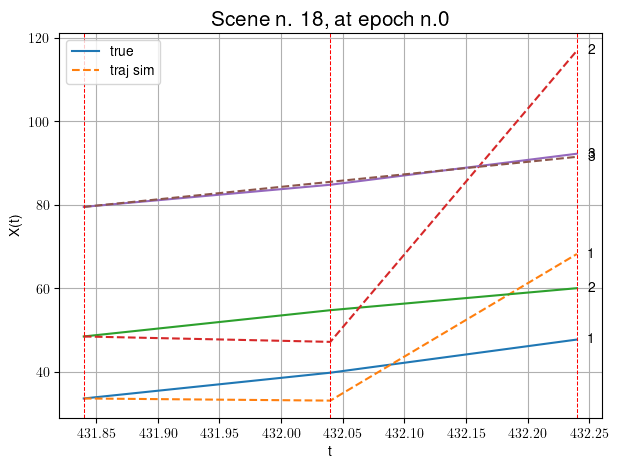


            Loss: 418.6668078611881
            gradient to update v0: -0.005610775998317455
            v0 updated: 30.00280538799916
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch n.50


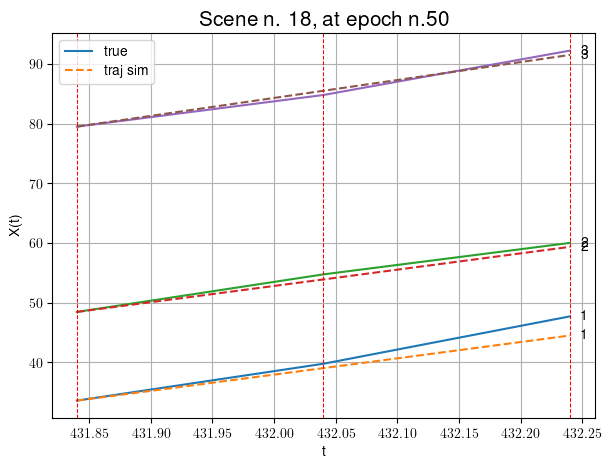


            Loss: 1.4448295961579334
            gradient to update v0: -0.0010300542284843173
            v0 updated: 30.069225853653982
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch n.100


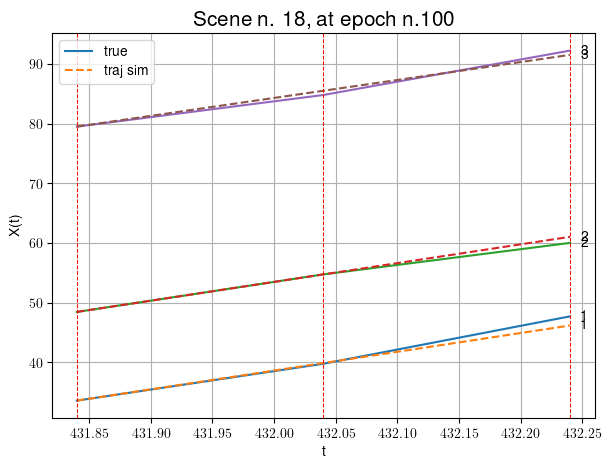


            Loss: 0.4901367184286365
            gradient to update v0: -0.00018910249038285587
            v0 updated: 30.081419653863055
----------------------------------------------------------------------------------------------------

Scene n. 24, time interval:    [500.64,501.04]
----------------------------------------------------------------------------------------------------
Epoch n.0


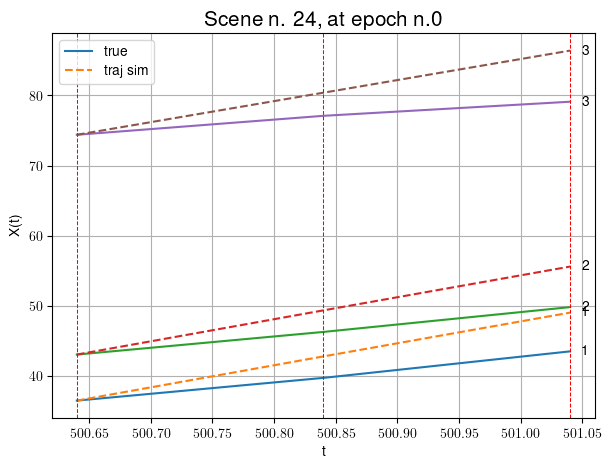


            Loss: 16.300000925910336
            gradient to update v0: 1.175908704988351
            v0 updated: 29.412045647505824
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch n.50


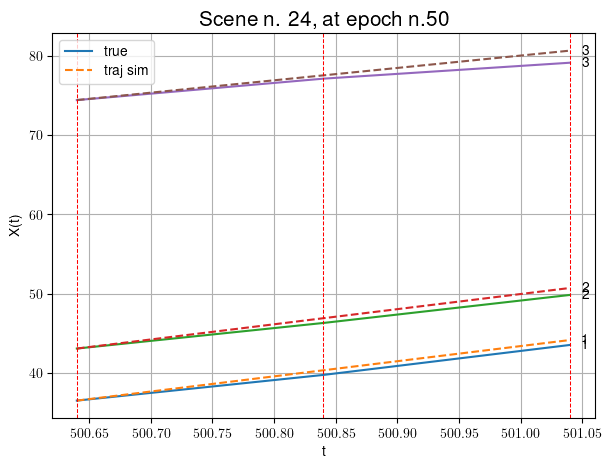


            Loss: 0.4847204394031164
            gradient to update v0: 0.2158791822695447
            v0 updated: 15.491617568076368
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch n.100


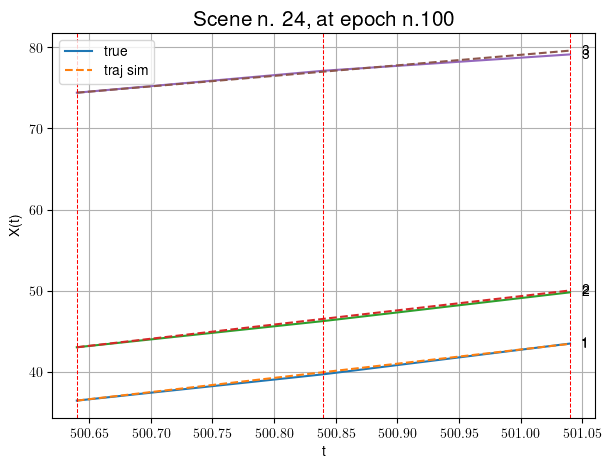


            Loss: 0.047248588527099365
            gradient to update v0: 0.03963217649442817
            v0 updated: 12.936035984337718
----------------------------------------------------------------------------------------------------

Scene n. 5, time interval:    [148.04,148.44]
----------------------------------------------------------------------------------------------------
Epoch n.0


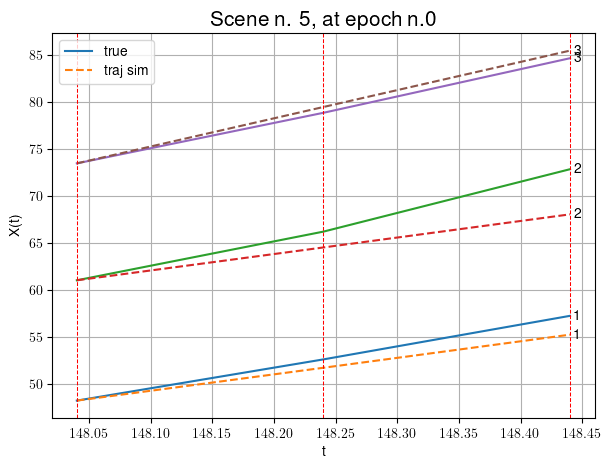


            Loss: 3.5282235310658017
            gradient to update v0: 0.15855622571851946
            v0 updated: 29.92072188714074
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch n.50


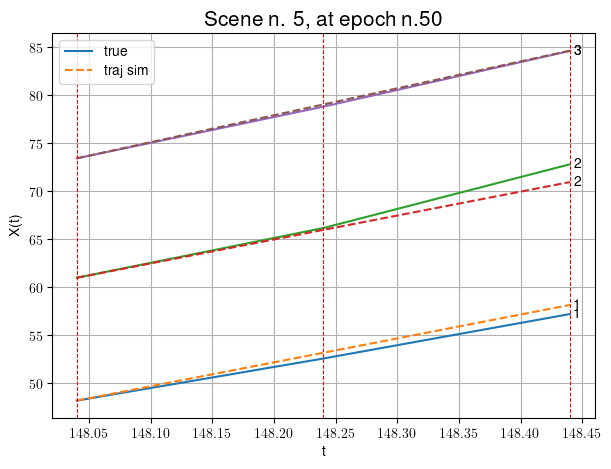


            Loss: 0.530846918898651
            gradient to update v0: 0.029108542361151356
            v0 updated: 28.043730478454126
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch n.100


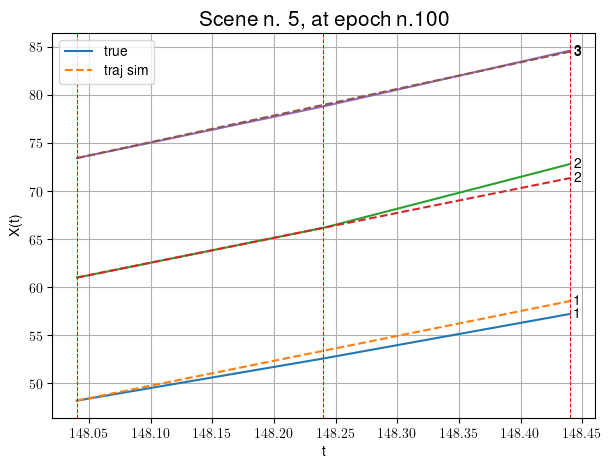


            Loss: 0.5110897575621329
            gradient to update v0: 0.00534389132033968
            v0 updated: 27.699143038362624
----------------------------------------------------------------------------------------------------

Scene n. 7, time interval:    [164.04,164.64]
----------------------------------------------------------------------------------------------------
Epoch n.0


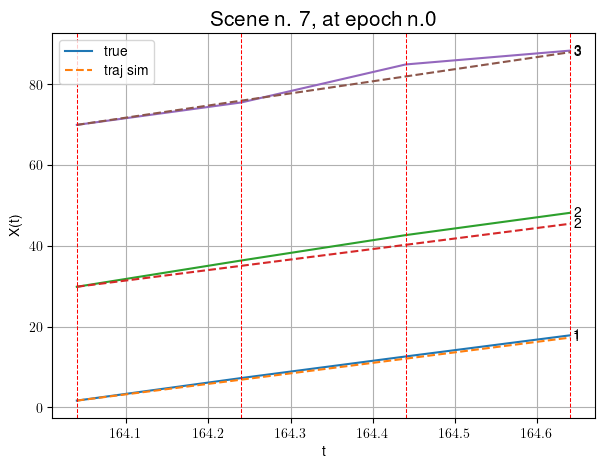


            Loss: 2.0663279110719976
            gradient to update v0: -0.1621900703793189
            v0 updated: 30.08109503518966
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch n.50


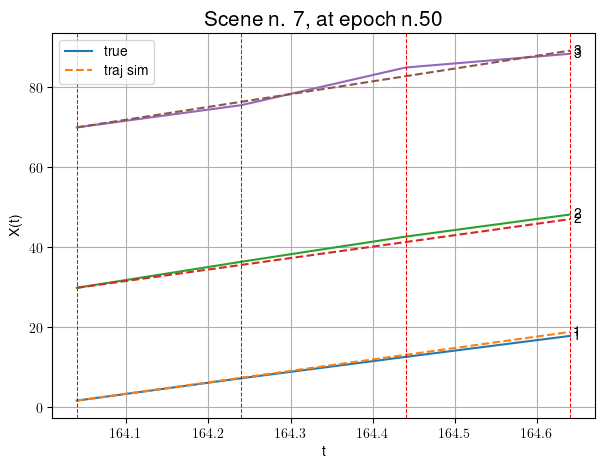


            Loss: 0.9251234799351065
            gradient to update v0: -0.029775661679550248
            v0 updated: 32.00110396133895
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch n.100


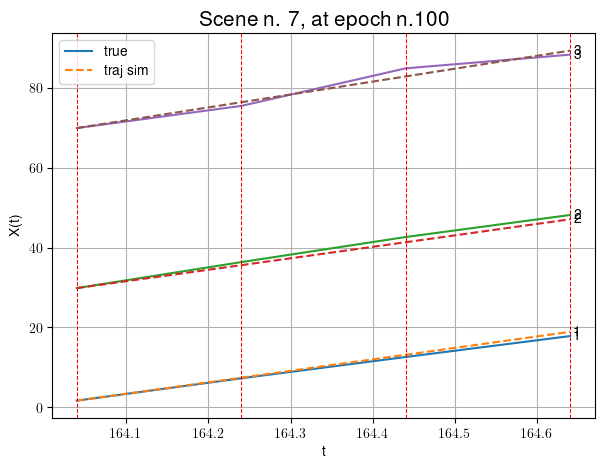


            Loss: 0.9072508290163407
            gradient to update v0: -0.005466364410284068
            v0 updated: 32.353588771739574
----------------------------------------------------------------------------------------------------

Scene n. 6, time interval:    [161.64,162.04]
----------------------------------------------------------------------------------------------------
Epoch n.0


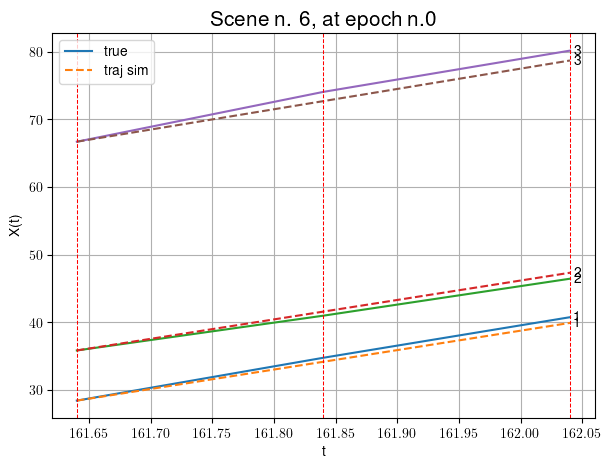


            Loss: 0.6886759631868481
            gradient to update v0: -0.3141210273342444
            v0 updated: 30.157060513667123
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch n.50


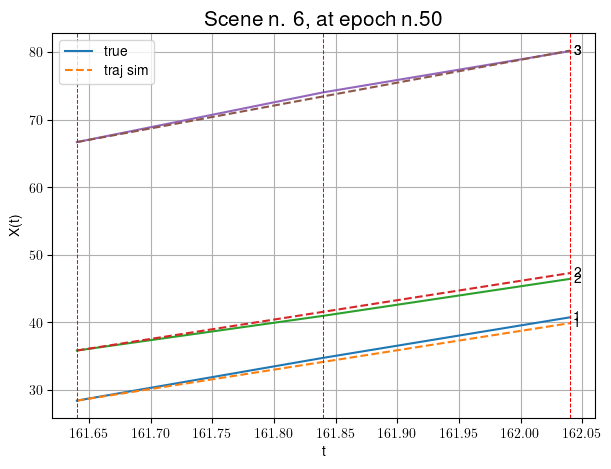


            Loss: 0.2842248981850169
            gradient to update v0: -0.05766790417235275
            v0 updated: 33.87563079951475
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch n.100


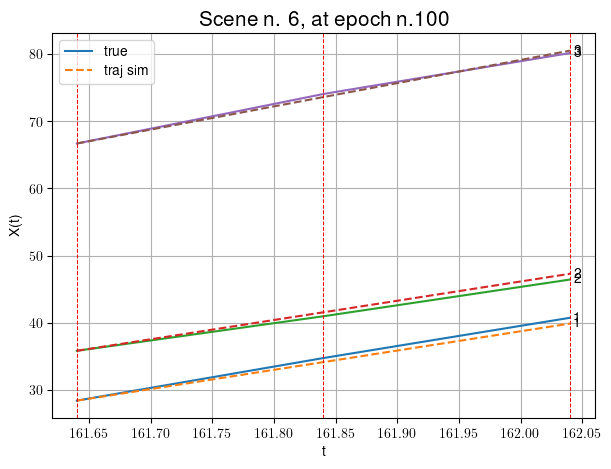


            Loss: 0.2814461004377315
            gradient to update v0: -0.010586961337115966
            v0 updated: 34.55830447062058
----------------------------------------------------------------------------------------------------


In [15]:
info_df = []

for scn in scn_train:
#for scn in scn_list:
    
    v0_scn = []
    
    tstamps = scn['Tarr']
    v0 = 30
    
    print("=="*50)
    print(f"\nScene n. {scn.name}, time interval:\
    [{fmt.format(tstamps[0])},{fmt.format(tstamps[-1])}]")
    
    for epoch in range(NUM_EPOCHS+1):
        
        t_list, x_list, _ = solve_nn_scn(scn, v0)
        _, x_list_matched = match_timestamps_scene(t_list, x_list)

        # Append v0 used, before to update it
        v0_scn.append(v0)
        
        # Update v0 with SGD
        v0_upd, loss_val, grads, g = SGD_v0(scn, x_list_matched, v0)
        v0 = v0_upd
        
        if epoch % nprint == 0:
            print("--"*50)
            print(f"Epoch n.{epoch}")

            # plot function
            t_ann_matched, trajs_ann_matched = match_timestamps_scene(t_list, x_list)
            tscale = 1+(tstamps[-1]-tstamps[0])/20000
            title = f"Scene n. {scn.name}, at epoch n.{epoch}"
            plot_scn(scn, trajs_ann_matched, title, xbal=0.01, ybal=0.05, scale=tscale)

            print(f"\n\
            Loss: {loss_val}\n\
            gradient to update v0: {g}\n\
            v0 updated: {v0}")
            print("--"*50)

    v0_scn_mean = np.array(v0_scn).mean()
    info_df.append([scn.name,v0_scn_mean])

    print("=="*50)

In [16]:
info_df

[[18, 30.059977584371083],
 [24, 17.429873588239257],
 [5, 28.305079474111974],
 [7, 31.733765281907484],
 [6, 33.35786358705408]]

In [17]:
for nscn, v0_scn_mean in info_df:
    print(f"Scene n.{nscn}: v0 mean is {v0_scn_mean}")

Scene n.18: v0 mean is 30.059977584371083
Scene n.24: v0 mean is 17.429873588239257
Scene n.5: v0 mean is 28.305079474111974
Scene n.7: v0 mean is 31.733765281907484
Scene n.6: v0 mean is 33.35786358705408


In [18]:
v0_list = [l[1] for l in info_df]
np.array(v0_list).mean()

28.177311903136776